# Determining What to Run Baseline Correction On

We need baseline corrections for all (good) entries in [this spreadsheet](https://onedrive.live.com/edit.aspx?resid=C3502B019E9CF5B9!323&ithint=file%2cxlsx&wdo=2&authkey=!AAb9dbohL6SwGeM); the goal is to determine which of these can share baseline corrections.

In [1]:
#Imports
import glob
import numpy as np
import pandas as pd
import lmfit as lf
import statistics as s
import matplotlib.pyplot as plt
from scipy import signal as sig
from R76Tools import *
#Settings
plt.style.use('./default.mplstyle')
datapath = "R76Data/"

## Keeping across different voltages

In this section, we will check whether the same baseline correction can be applied to the full dataset originally included in `Hv1_Calibration.ipynb`.

In [2]:
#Start by importing and organizing our data
ser = ["07220822_1828","07220826_1219","07220826_1536","07220826_2007","07220827_1153","07220830_1724"]#["07220702_0911"]
lab = ["0V","-4V","-21V","-65V","-84V","-84V"] #["data"]

e=[]; z=[];
for series in ser:
    filelist = glob.glob(datapath+series+"/umn*.root")
    e_chain,z_chain = makechain(filelist,fittingfilters)
    e.append(e_chain);z.append(z_chain)

for i,x in enumerate(z):
    z[i] = pd.concat([x,e[i]],axis=1)
    
for x in z:
    x['crand'] = crand(x)
    x['pt_keV'] = pt_keV(x)
    x['cam'] =  cam(x)
    x['cphi1'] = cphi1(x)
    x['PSUMbs'] = PSUMbs(x)

In [3]:
#Now we do the linear fit on the last dataset, as before
points = [[0,149],[1200,96]]; 
m = (points[1][1]-points[0][1])/(points[1][0]-points[0][0]); b = points[0][1]

def f(x,m=m,b=b): return m*x+b #Define the equation of a line for fitting.

#Define our data points with our new y > 50 fit
x = z[4]['PSUMbs'][~z[4]['crand'] & z[4]['cphi1'] & z[4]['cam'] & (z[4]['pt_keV']>50)]-18000
y = z[4]['pt_keV'][~z[4]['crand'] & z[4]['cphi1'] & z[4]['cam'] & (z[4]['pt_keV']>50)]

#Set up to fit
mod = lf.Model(f); params = mod.make_params()
params.add('m',value=-0.2,max=0,min=-1);params.add('b',value=150,min=0) #give reasonable constraints
fit = mod.fit(y,params,x=x)
#fit #we've seen this before

In [4]:
#Then the Gaussian fit
bins = np.linspace(fit.best_values['b'],fit.best_values['b']+30,30)
h = np.histogram(y[(x<50) & (x>-50)],bins=bins); hy = h[0]; hx = h[1] #Get hist values from the plot
hx = (hx[:-1]+hx[1:])/2

#Find the peaks
peaks, _ = sig.find_peaks(hy,height=np.mean(hy)+1) #Don't detect peaks beneath mean value
#Set up and fit a gaussian near the median of all peaks. Scaled because hy is not normalized.
def gaussian(x,mu,sigma,A): return A*(2*np.pi)**(-1/2)/sigma*np.exp(-(x-mu)**2/(2*sigma**2))
modg = lf.Model(gaussian); paramsg = modg.make_params()
med = s.median(hx[peaks])
paramsg.add('mu',value=med,min=fit.best_values['b'],max=max(hx[peaks]))
paramsg.add('sigma',value=5,min=0)
paramsg.add('A',value=1,min=0,vary=False)
dist = hx[peaks][math.floor(len(peaks)/2)+1] - hx[peaks][math.floor(len(peaks)/2)] #get diff between medianish
rangemin = med-3*dist; rangemax = med+3*dist
rangeslice = (hx>=rangemin) & (hx<rangemax)
hyscaled = hy[rangeslice]/sum(hy[rangeslice])/(hx[1]-hx[0])
fitg = modg.fit(hyscaled,params=paramsg,x=hx[rangeslice])
#fitg

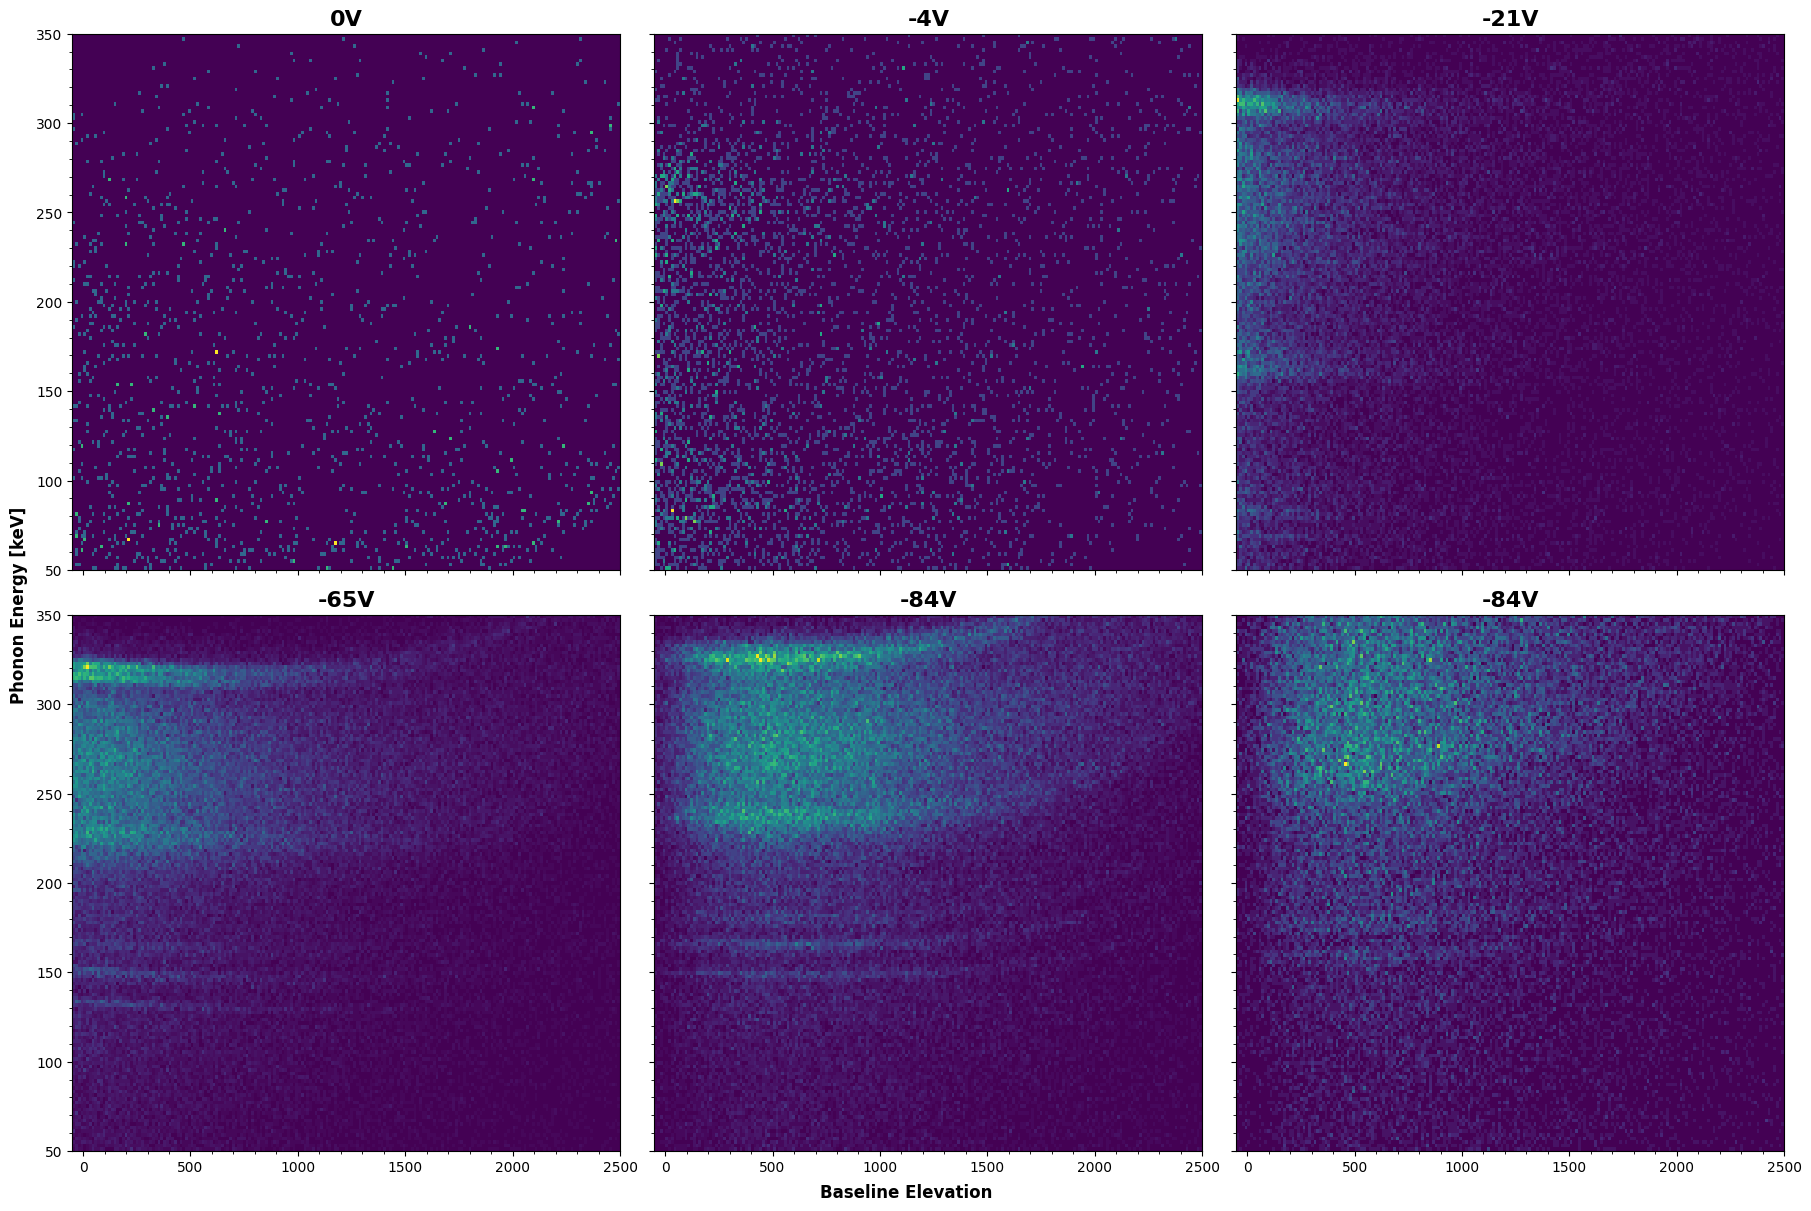

In [12]:
fig,ax = plt.subplots(2,3,figsize=(18,12),sharey=True,sharex=True)

bins = [np.linspace(-50,2500,200),np.linspace(50,350,150)]
G = fit.best_values['m']/fitg.best_values['mu']
for x in z:
    x['bscorr_gau'] = x['pt_keV']/(1.+(x['PSUMbs']-18000.)*G)
    
#Plot
for i,axis in enumerate(ax):
    for j,axis in enumerate(axis):
        axis.set_title(lab[i*3+j])
        x = z[i*3+j]
        axis.hist2d(x['PSUMbs'][~x['crand']]-18000,x['bscorr_gau'][~x['crand']],bins=bins)

fig.supxlabel("Baseline Elevation"); fig.supylabel("Phonon Energy [keV]")
plt.show()

We took the correction from the bottom center plot. It may translate to other datasets; the -21V looks okay, although it doesn't show much beyond baseline elevation 500. The 65V data seems mostly okay, and the other set of 84V data seems off but this is most likely due to there being a gap of a few days. The 0V and -4V data aren't readable. Let's check if they're readable before the adjustment:

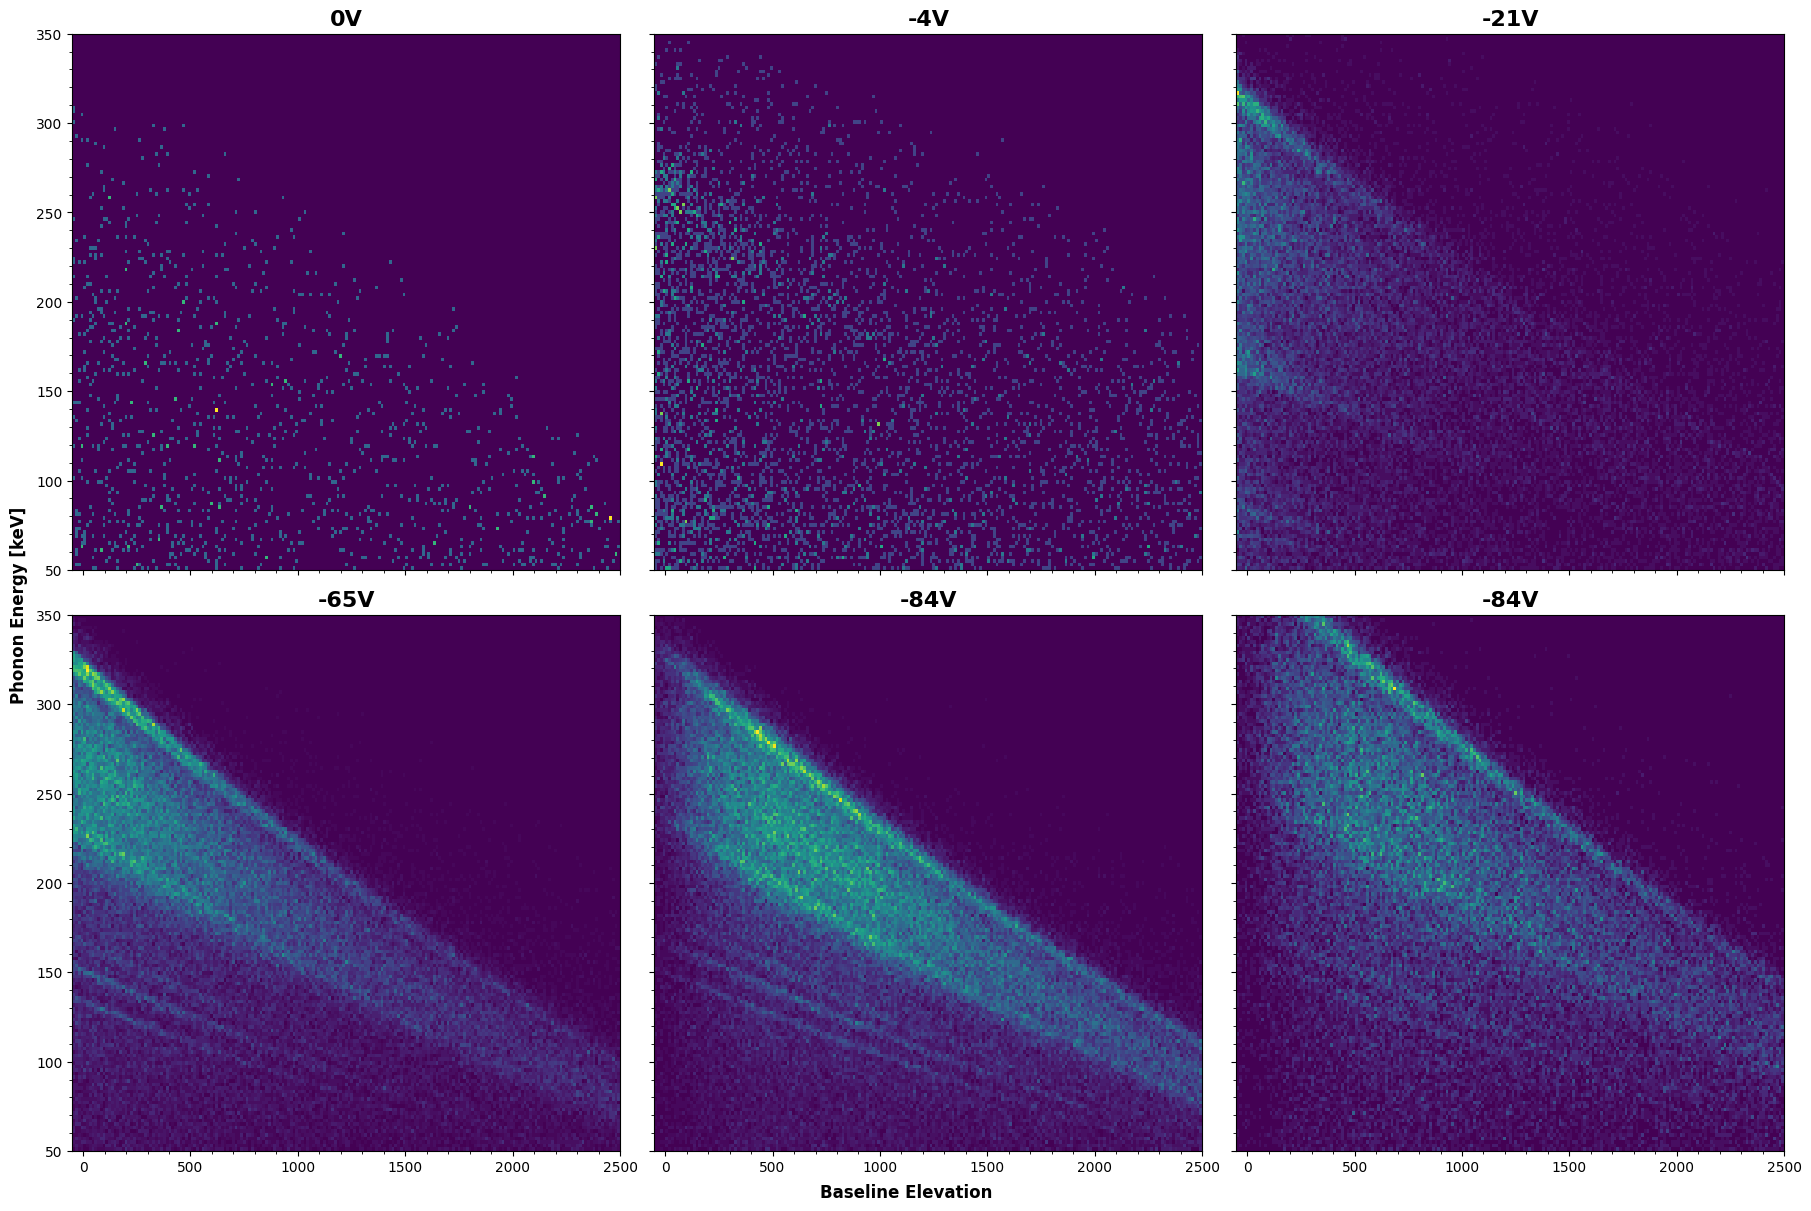

In [13]:
fig,ax = plt.subplots(2,3,figsize=(18,12),sharey=True,sharex=True)

bins = [np.linspace(-50,2500,200),np.linspace(50,350,150)]
G = fit.best_values['m']/fitg.best_values['mu']
for x in z:
    x['bscorr_gau'] = x['pt_keV']/(1.+(x['PSUMbs']-18000.)*G)
    
#Plot
for i,axis in enumerate(ax):
    for j,axis in enumerate(axis):
        axis.set_title(lab[i*3+j])
        x = z[i*3+j]
        axis.hist2d(x['PSUMbs'][~x['crand']]-18000,x['pt_keV'][~x['crand']],bins=bins)
del bins #done with this
fig.supxlabel("Baseline Elevation"); fig.supylabel("Phonon Energy [keV]")
plt.show()

So, yes, it seems the issue is more with the data itself than the corection. Therefore, mismatched voltages should be okay. We may wish to evaluate any others after the fact.

## Keeping Across Time
From the above plots, it seems like data from the same day is most likely okay to keep the same correction, but we start to see noticeable errors after three days. We will now look at the first dataset that spans two days to see when the disparity becomes apparent.

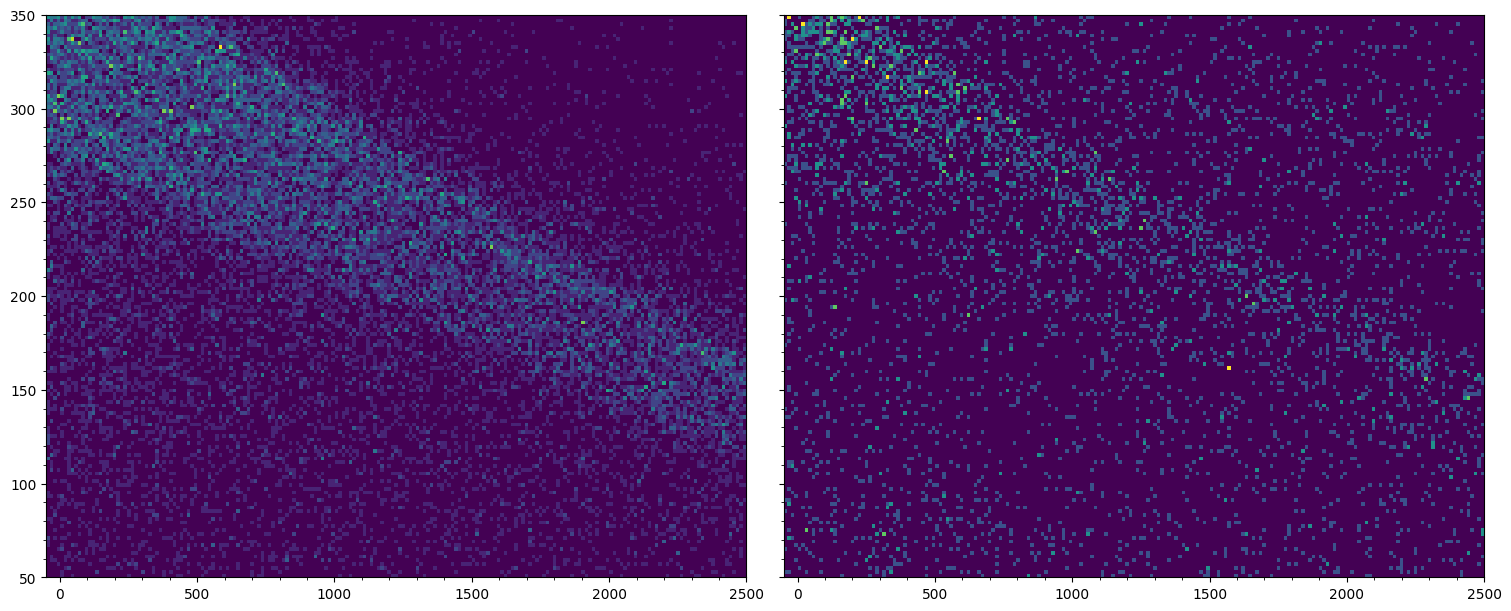

In [22]:
#Import a new dataset across two days
ser = ["07220420_0842","07220421_1010"]
lab = ["0V","0V"]

e=[]; z=[];
for series in ser:
    filelist = glob.glob(datapath+series+"/umn*.root")
    e_chain,z_chain = makechain(filelist,fittingfilters)
    e.append(e_chain);z.append(z_chain)

for i,x in enumerate(z):
    z[i] = pd.concat([x,e[i]],axis=1)
    
for x in z:
    x['crand'] = crand(x)
    x['pt_keV'] = pt_keV(x)
    x['cam'] =  cam(x)
    x['cphi1'] = cphi1(x)
    x['PSUMbs'] = PSUMbs(x)
    
fig,ax = plt.subplots(1,2,figsize=(15,6),sharey=True)

z[0].keys()

for i,axis in enumerate(ax):
    axis.hist2d(z[i]['PSUMbs'][~z[i]['crand']]-18000,z[i]['pt_keV'][~z[i]['crand']],bins=bins)

StatisticsError: no median for empty data

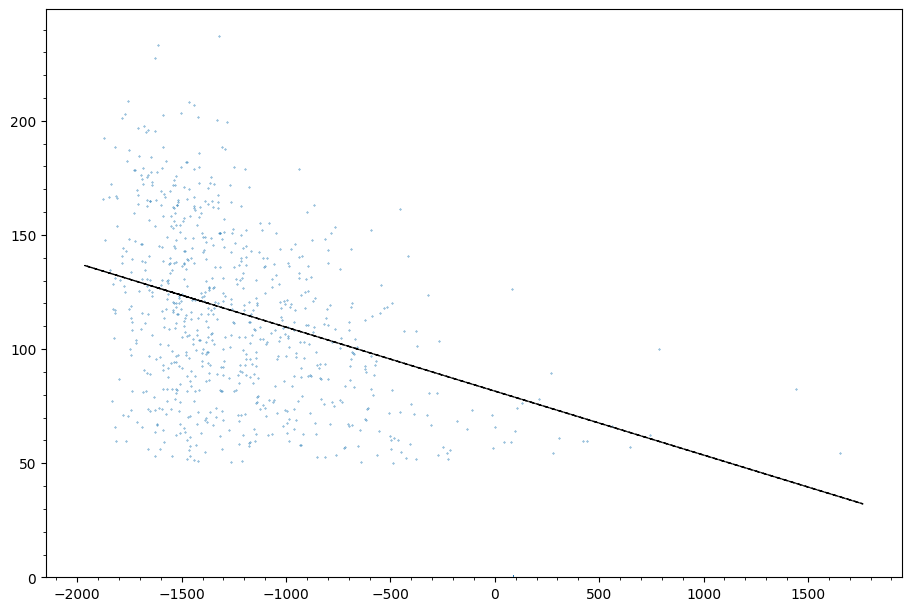

In [40]:
#Let's try fitting this data
x = z[0]['PSUMbs'][~z[0]['crand'] & z[0]['cam'] & (z[0]['pt_keV']>50)]-18000
y = z[0]['pt_keV'][~z[0]['crand'] & z[0]['cam'] & (z[0]['pt_keV']>50)]

#Set up to fit
mod = lf.Model(f); params = mod.make_params()
params.add('m',value=-0.2,max=0,min=-1);params.add('b',value=150,min=0) #give reasonable constraints
fit = mod.fit(y,params,x=x)

plt.scatter(z[0]['PSUMbs'][~z[0]['crand'] & z[0]['cphi1'] & z[0]['cam'] & (z[0]['pt_keV']>50)]-18000,
            z[0]['pt_keV'][~z[0]['crand'] & z[0]['cphi1'] & z[0]['cam'] & (z[0]['pt_keV']>50)],s=0.1)
plt.plot(x,fit.best_fit,color='k',linewidth=1,label='Fit')

bins = np.linspace(fit.best_values['b'],fit.best_values['b']+30,30)
h = plt.hist(y[(x<50) & (x>-50)],bins=bins); hy = h[0]; hx = h[1] #Get hist values from the plot
hx = (hx[:-1]+hx[1:])/2

#Find the peaks
peaks, _ = sig.find_peaks(hy,height=np.mean(hy)+1) #Don't detect peaks beneath mean value
#Set up and fit a gaussian near the median of all peaks. Scaled because hy is not normalized.
def gaussian(x,mu,sigma,A): return A*(2*np.pi)**(-1/2)/sigma*np.exp(-(x-mu)**2/(2*sigma**2))
modg = lf.Model(gaussian); paramsg = modg.make_params()
med = s.median(hx[peaks])
paramsg.add('mu',value=med,min=fit.best_values['b'],max=max(hx[peaks]))
paramsg.add('sigma',value=5,min=0)
paramsg.add('A',value=1,min=0,vary=False)
dist = hx[peaks][math.floor(len(peaks)/2)+1] - hx[peaks][math.floor(len(peaks)/2)] #get diff between medianish
rangemin = med-3*dist; rangemax = med+3*dist
rangeslice = (hx>=rangemin) & (hx<rangemax)
hyscaled = hy[rangeslice]/sum(hy[rangeslice])/(hx[1]-hx[0])
fitg = modg.fit(hyscaled,params=paramsg,x=hx[rangeslice])

fig,ax = plt.subplots(1,2,figsize=(18,12),sharey=True,sharex=True)

bins = [np.linspace(-50,2500,200),np.linspace(50,350,150)]
G = fit.best_values['m']/fitg.best_values['mu']
for x in z:
    x['bscorr_gau'] = x['pt_keV']/(1.+(x['PSUMbs']-18000.)*G)
    
#Plot
for i,axis in enumerate(ax):
    for j,axis in enumerate(axis):
        axis.set_title(lab[i*3+j])
        x = z[i*3+j]
        axis.hist2d(x['PSUMbs'][~x['crand']]-18000,x['bscorr_gau'][~x['crand']],bins=bins)

fig.supxlabel("Baseline Elevation"); fig.supylabel("Phonon Energy [keV]")
plt.show()

In [36]:
print(bins)
print(y[(x<50) & (x>-50)])

[ 73.08371828  74.11820104  75.1526838   76.18716656  77.22164932
  78.25613207  79.29061483  80.32509759  81.35958035  82.39406311
  83.42854587  84.46302863  85.49751139  86.53199414  87.5664769
  88.60095966  89.63544242  90.66992518  91.70440794  92.7388907
  93.77337345  94.80785621  95.84233897  96.87682173  97.91130449
  98.94578725  99.98027001 101.01475276 102.04923552 103.08371828]
2990      65.773033
29401     59.411274
53878     71.028926
124789    56.756901
Name: pt_keV, dtype: float64


Current proposed groupings:  
1. `07220330_1639`  
2. `07220405_1646:07220406_1720` (2)
3. `07220420_0842:07220421_1010` (2)
4. `07220422_1144:07220422_1250` (2)
5. `07220425_0722:07220426_2022` (6)